In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d muhammadhananasghar/oace-open-and-close-eyes-dataset

 99% 513M/518M [00:11<00:00, 69.6MB/s]
100% 518M/518M [00:12<00:00, 45.2MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/oace-open-and-close-eyes-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [17]:
import os
import random
import shutil

In [18]:
dataset_path = '/content/OACE'

# paths for train and validation directories
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

In [19]:
# Creating train and validation directories
for folder_path in [train_dir, val_dir]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [20]:
# Defining the paths for train and val subdirectories for open and close eyes
train_open_dir = os.path.join(train_dir, 'open')
train_close_dir = os.path.join(train_dir, 'close')
val_open_dir = os.path.join(val_dir, 'open')
val_close_dir = os.path.join(val_dir, 'close')

In [21]:
# Creating 'open' and 'close' subdirectories for both train and val directories
for folder_path in [train_open_dir, train_close_dir, val_open_dir, val_close_dir]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [22]:
# Iterating through the OACE directory
for label in ['open', 'close']:
    images_path = os.path.join(dataset_path, label)
    image_files = os.listdir(images_path)

    # shuffling
    random.shuffle(image_files)

    # determine the split index
    split_index = int(0.8 * len(image_files)) # 80% train, 20% val

    # Move images to train_directory
    for img_file in image_files[:split_index]:
        src_path = os.path.join(images_path, img_file)
        dest_path = os.path.join(train_open_dir if label == 'open' else train_close_dir, img_file)
        shutil.copy(src_path, dest_path)

    # Move images to val directory
    for img_file in image_files[split_index:]:
        src_path = os.path.join(images_path, img_file)
        dest_path = os.path.join(val_open_dir if label == 'open' else val_close_dir, img_file)
        shutil.copy(src_path, dest_path)

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [24]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/OACE/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (128, 128)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/OACE/val',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (128, 128)
)

Found 78288 files belonging to 2 classes.
Found 19572 files belonging to 2 classes.


In [25]:
# Creating a CNN model

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
2447/2447 [==============================] - 62s 23ms/step - loss: 0.2592 - accuracy: 0.9564 - val_loss: 0.0544 - val_accuracy: 0.9829
Epoch 2/10
2447/2447 [==============================] - 74s 30ms/step - loss: 0.0653 - accuracy: 0.9784 - val_loss: 0.0478 - val_accuracy: 0.9848
Epoch 3/10
2447/2447 [==============================] - 67s 27ms/step - loss: 0.0485 - accuracy: 0.9851 - val_loss: 0.0539 - val_accuracy: 0.9840
Epoch 4/10
2447/2447 [==============================] - 68s 28ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.0501 - val_accuracy: 0.9855
Epoch 5/10
2447/2447 [==============================] - 59s 24ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0281 - val_accuracy: 0.9913
Epoch 6/10
2447/2447 [==============================] - 57s 23ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0361 - val_accuracy: 0.9903
Epoch 7/10
2447/2447 [==============================] - 55s 23ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.0272 -

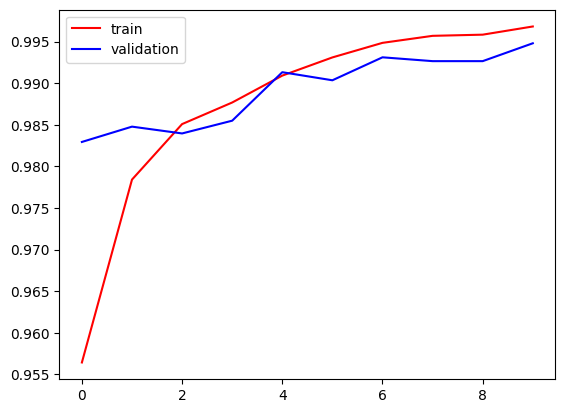

In [29]:
import matplotlib.pyplot as plt

# Plotting train VS validation accuracy
plt.plot(
    history.history['accuracy'],
    color = 'red',
    label = 'train'
)

plt.plot(
    history.history['val_accuracy'],
    color = 'blue',
    label = 'validation'
)

plt.legend()
plt.show()

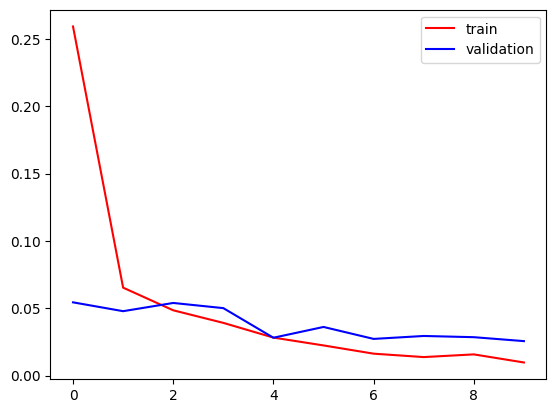

In [30]:
# Plotting train VS validation loss
plt.plot(
    history.history['loss'],
    color = 'red',
    label = 'train'
)

plt.plot(
    history.history['val_loss'],
    color = 'blue',
    label = 'validation'
)

plt.legend()
plt.show()

Now testing the model prediction on a test input randomly taken from internet

In [32]:
import cv2 as cv

In [33]:
test_img_open = cv.imread('/content/test_img_open_eye.jpg')
test_img_close = cv.imread('/content/test_img_close_eye.jpg')

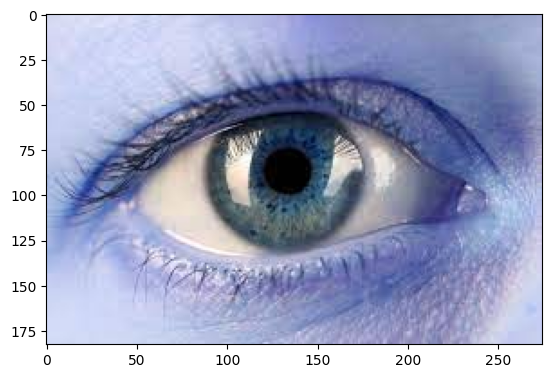

In [34]:
plt.imshow(test_img_open)

In [37]:
test_img_open.shape

(183, 275, 3)

In [38]:
test_img_open = cv.resize(test_img_open, (128, 128))
test_img_open.shape

(128, 128, 3)

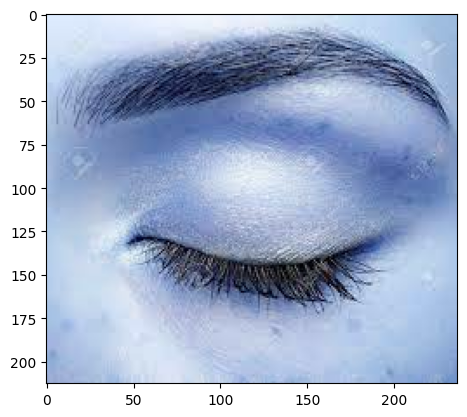

In [35]:
plt.imshow(test_img_close)

In [39]:
test_img_close.shape

(213, 237, 3)

In [40]:
test_img_close = cv.resize(test_img_close, (128, 128))
test_img_close.shape

(128, 128, 3)

In [42]:
test_input_open = test_img_open.reshape((1,128,128,3))
test_input_close = test_img_close.reshape((1,128,128,3))

In [43]:
model.predict(test_input_open)

1/1 [==============================] - 0s 313ms/step


array([[1.]], dtype=float32)

In [46]:
model.predict(test_input_close)

1/1 [==============================] - 0s 18ms/step


array([[9.722757e-19]], dtype=float32)

In [48]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))